<a href="https://colab.research.google.com/github/bksat90/StockPrediction/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# Fetch stock data from Yahoo Finance
ticker = 'IBM'
# 2 years data
data = yf.download(ticker, start="2021-12-01", end="2023-11-30")

# printing the head of the imported data
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,118.250000,118.930000,116.849998,116.919998,106.124695,5958300
2021-12-02,117.370003,117.980003,116.559998,116.900002,106.106537,5267100
2021-12-03,117.360001,119.360001,117.360001,118.839996,107.867401,6630100
2021-12-06,119.400002,121.150002,119.400002,119.910004,108.838631,4785600
2021-12-07,120.480003,122.080002,120.070000,121.580002,110.354431,5194000


In [3]:
# seperate the close data which will be used for prediction
close_data = data['Close'].values.reshape(-1,1)

In [4]:
# preprocessing - rescaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(close_data)

## Creating the time series data structure with structure N * T * D
# N = number of samples, T = block/series size = look_back, D = features = 1
look_back = 40

# 75% data is considered as train data
train_size = int(len(scaled_data) * 0.70)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

# generates time series data
train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)

In [5]:
# builds the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,
                    input_shape=(look_back, 1)))
model.add(LSTM(units=100,return_sequences = True))
model.add(LSTM(units=100))
model.add(Dense(1, activation='tanh'))

In [6]:
# display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 40, 100)           60400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 151301 (591.02 KB)
Trainable params: 151301 (591.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


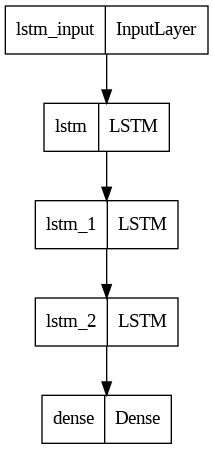

In [7]:
# display the model
plot_model(model)

In [8]:
# compiles the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics = ['accuracy'])

In [9]:
# fit the model
r = model.fit(train_generator,
              validation_data=(test_generator),
              epochs=10)

Epoch 1/10
16/16 [==============================] - 22s 299ms/step - loss: 0.4717 - accuracy: 0.0000e+00 - val_loss: 0.4249 - val_accuracy: 0.0000e+00
Epoch 2/10
16/16 [==============================] - 1s 75ms/step - loss: 0.3702 - accuracy: 0.0000e+00 - val_loss: 0.5034 - val_accuracy: 0.0000e+00
Epoch 3/10
16/16 [==============================] - 1s 55ms/step - loss: 0.3158 - accuracy: 0.0000e+00 - val_loss: 0.3960 - val_accuracy: 0.0000e+00
Epoch 4/10
16/16 [==============================] - 1s 57ms/step - loss: 0.3194 - accuracy: 0.0000e+00 - val_loss: 0.3627 - val_accuracy: 0.0000e+00
Epoch 5/10
16/16 [==============================] - 1s 54ms/step - loss: 0.2576 - accuracy: 0.0000e+00 - val_loss: 0.4236 - val_accuracy: 0.0000e+00
Epoch 6/10
16/16 [==============================] - 1s 95ms/step - loss: 0.2530 - accuracy: 0.0000e+00 - val_loss: 0.3456 - val_accuracy: 0.0000e+00
Epoch 7/10
16/16 [==============================] - 1s 55ms/step - loss: 0.2353 - accuracy: 0.0000e+00 -

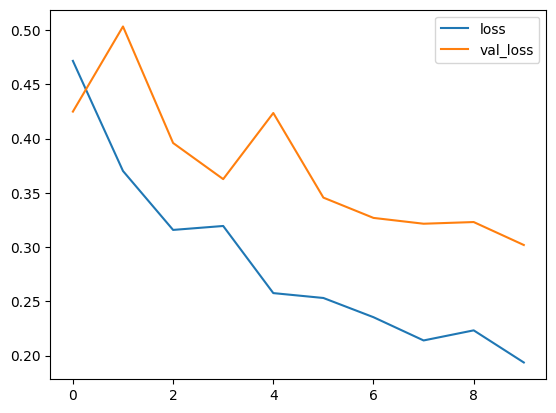

In [10]:
# plot the loss vs value loss of the model for the training data
plt.figure()
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [11]:
# Predicting on the test data
# rnn_predictions = rnn_model.predict(test_generator)
data_predictions = model.predict(test_generator)

# Invert predictions
# rnn_predictions = scaler.inverse_transform(rnn_predictions)
data_predictions = scaler.inverse_transform(data_predictions)
actual_close_prices = scaler.inverse_transform(test_data[look_back:])

151/151 [==============================] - 2s 6ms/step


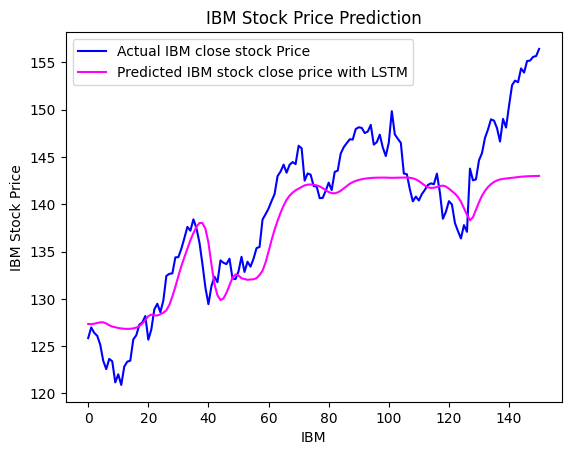

In [17]:
# Plot the data
plt.figure()
plt.plot(actual_close_prices, color='blue', label='Actual IBM close stock Price')
plt.plot(data_predictions, color='magenta', label='Predicted IBM stock close price with LSTM')
plt.title('IBM Stock Price Prediction')
plt.xlabel('IBM')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()